In [1]:
:ext TypeSynonymInstances
:ext FlexibleInstances
:ext LambdaCase

In [2]:
import Utils
import Data.Tuple.Extra (uncurry3, both, first, second, (***))
import Data.Bool (bool)
import Data.List.Extra (sortOn, dropEnd, enumerate)
import Data.Ord (Down(..), comparing)
import Data.Function (on, (&))
import Data.Maybe (fromJust)
import Control.Monad (replicateM, forM, forM_)
import Control.Monad.Trans.State
import Control.Monad.Trans.Class (lift)
import Data.IORef
import qualified Data.Map as Map

In [3]:
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate
import qualified System.Random.MWC.Probability as MWC
-- import Tyche.Inference.LikelihoodWeighting

In [4]:
import Graphics.Vega.VegaLite (toHtmlWith)
import IHaskell.Display (html)
import Data.Text.Lazy (pack, unpack)

# Setting Things Up

## The Model

Worlds are distinguished only by the heights of the individuals at issue

In [5]:
data E = John | Mary deriving (Eq, Enum, Show, Bounded)

domain :: [E]
domain = enumerate

data World = World {label :: String, ht :: E -> Int}

instance Eq World where
  w == w' = show w == show w'
  
instance Ord World where
  compare = comparing (\s -> map (ht s) domain)

instance Show World where
  show (World l _) = l

But what we reason about are effectively **pointed distributions**, which include information about individuals' heights *relative to other heights of individuals*

In [6]:
type Index = (World, Int)
instance {-# OVERLAPPING #-} Show Index where
  show (w,i) = show w ++ ";" ++ show i

A **proposition** is a set of these centered distributions

In [7]:
type Prop = [Index]

For the sake of computational efficiency, we imagine that there are only 11 possible heights

In [8]:
mkWorld :: (Int, Int) -> World
mkWorld (d, d') = World ("j" ++ show d ++ "m" ++ show d') hts
  where hts = \case {John -> d; Mary -> d'}
  
heights = [1 .. 11]
universe = [mkWorld (h, h') | h <- heights, h' <- heights]

Again for efficiency's sake, not all world-center pairs are considered possible. The median height is assumed to fall between $4$ and $8$, and everyone's height is assumed to fall within $2$ steps of the median: 

\begin{equation} C = \bigcap_{x\in D_e} \Bigl\{\langle w, \mu\rangle \Bigm\vert 4 \leq \mu \leq 8,\ -3 \leq \mu - \textsf{ht}_{w}(x) \leq 3\Bigr\} \end{equation}

In [9]:
sigma = 3
indices = [(w, mu) | mu <- drop sigma . dropEnd sigma $ heights, w <- universe, all (\x -> abs (ht w x - mu) <= sigma) domain]
indices

[j1m1;4,j1m2;4,j1m3;4,j1m4;4,j1m5;4,j1m6;4,j1m7;4,j2m1;4,j2m2;4,j2m3;4,j2m4;4,j2m5;4,j2m6;4,j2m7;4,j3m1;4,j3m2;4,j3m3;4,j3m4;4,j3m5;4,j3m6;4,j3m7;4,j4m1;4,j4m2;4,j4m3;4,j4m4;4,j4m5;4,j4m6;4,j4m7;4,j5m1;4,j5m2;4,j5m3;4,j5m4;4,j5m5;4,j5m6;4,j5m7;4,j6m1;4,j6m2;4,j6m3;4,j6m4;4,j6m5;4,j6m6;4,j6m7;4,j7m1;4,j7m2;4,j7m3;4,j7m4;4,j7m5;4,j7m6;4,j7m7;4,j2m2;5,j2m3;5,j2m4;5,j2m5;5,j2m6;5,j2m7;5,j2m8;5,j3m2;5,j3m3;5,j3m4;5,j3m5;5,j3m6;5,j3m7;5,j3m8;5,j4m2;5,j4m3;5,j4m4;5,j4m5;5,j4m6;5,j4m7;5,j4m8;5,j5m2;5,j5m3;5,j5m4;5,j5m5;5,j5m6;5,j5m7;5,j5m8;5,j6m2;5,j6m3;5,j6m4;5,j6m5;5,j6m6;5,j6m7;5,j6m8;5,j7m2;5,j7m3;5,j7m4;5,j7m5;5,j7m6;5,j7m7;5,j7m8;5,j8m2;5,j8m3;5,j8m4;5,j8m5;5,j8m6;5,j8m7;5,j8m8;5,j3m3;6,j3m4;6,j3m5;6,j3m6;6,j3m7;6,j3m8;6,j3m9;6,j4m3;6,j4m4;6,j4m5;6,j4m6;6,j4m7;6,j4m8;6,j4m9;6,j5m3;6,j5m4;6,j5m5;6,j5m6;6,j5m7;6,j5m8;6,j5m9;6,j6m3;6,j6m4;6,j6m5;6,j6m6;6,j6m7;6,j6m8;6,j6m9;6,j7m3;6,j7m4;6,j7m5;6,j7m6;6,j7m7;6,j7m8;6,j7m9;6,j8m3;6,j8m4;6,j8m5;6,j8m6;6,j8m7;6,j8m8;6,j8m9;6,j9m3;6,j9m4;6,j9m5;

## The Language

We have a marked utterance, an unmarked utterance, and a null utterance (the least marked)

In [10]:
data Utt = UNone | UTall | UShrt
  deriving (Eq, Show, Ord, Enum, Bounded)

utterances = enumerate

A **lexicon** is a denotation function mapping utterances to propositions

In [11]:
data Lexicon = Lex {lexID :: Int, den :: Utt -> Prop}
instance Show Lexicon where
  show (Lex _ f) = "C = " ++ show (f UNone) ++ "; E = " ++ show (f UTall)
instance Eq Lexicon where
  (Lex m _) == (Lex n _) = m == n
instance Ord Lexicon where
  (Lex m _) <= (Lex n _) = m <= n

## Rational Agents

In [12]:
-- Initialize reference cell for storing results to speed up computations
type Cache = IORef (Int, Map.Map (Int, Utt, Lexicon) (Dist Index))
cacheRef <- newIORef (0, Map.empty) :: IO Cache

An $n$-level agent reasoning about `a` given `k` is a graphical model (supplemented with a memory, for efficiency)
- if the problem is old, the posterior distribution is returned from memory
- if the problem is new, then priors over indices, messages, and lexica are fed to a node computing the posterior distribution over `a`

In [13]:
data Priors = Priors {ip :: Model Index, up :: Model Utt, lp :: Model Lexicon}
type Agent k a = Priors -> Cache -> (Int, k, Lexicon) -> Model a
type AgentPlain k a = Priors -> (Int, k, Lexicon) -> Model a

* A speaker trying to describe index $i$ is an agent that chooses an utterance $u$ in proportion to its prior probability (its cost) and the likelihood that a listener would assign to $i$ upon hearing $u$
* A listener trying to interpret an utterance $u$ is an agent that chooses an index $i$ in proportion to its prior probability and the likelihood that a speaker would assign to $u$ upon trying to describe $i$

In [14]:
alpha :: Double
alpha = 4

speaker :: Agent Index Utt
speaker priors ref (n,i,l) =
  do u <- up priors
     if null (den l u)
       then weight negInf
       else do lnr <- lift $ memoize ref (listener priors ref) (n-1,u,l)
               weight $ alpha * logProb lnr i
     return u
     
{--
speaker :: World -> Params -> (Utt -> Params -> Prop) -> Agent Utt
speaker w c interp priors = do
  u <- up priors
  if null (interp u c) -- if the message is contradictory under the hypothesized lexicon
    then weight negInf
    else weight $ alpha * logProb (enumD $ literal u c interp priors) w
  return u
--}

listener :: Agent Utt Index
listener priors ref (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speaker priors ref (n,index,interp)
         observe spr u
         return index
  | otherwise =
      do index  <- ip priors
         condition (index `elem` den l u)
         return index    

{--
speakerPlain :: AgentPlain Index Utt
speakerPlain priors (n,i,l) =
  do u   <- up priors
     lnr <- lift $ enumD $ listenerPlain priors (n-1,u,l)
     weight $ alpha * logProb lnr i
     return u

listenerPlain :: AgentPlain Utt Index
listenerPlain priors (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speakerPlain priors (n,index,interp)
         observe spr u
         return index
  | otherwise =
      do index <- ip priors
         condition (index `elem` den l u)
         return index
--}

Line 32: Reduce duplication
Found:
index <- ip priors
condition (index `elem` den l u)
return index

Why not:
Combine with -:52:10

# Priors

Prior belief about indices is that people are normally sized. That is, the median height is unknown, but whatever it is, it is more likely that John and Mary are close to that height than that they are far away from it. Their respective heights are considered statistically independent.

In [15]:
indicesPriorFlat :: Model Index
indicesPriorFlat =
  do (w,i) <- unif indices
     forM_ domain $ \x ->
       observe (Normal 0 1.85) (fromIntegral $ ht w x - i)
     return (w,i)

Here we only show the joint distribution of John's height and the median height. The distribution over Mary's height is identical.

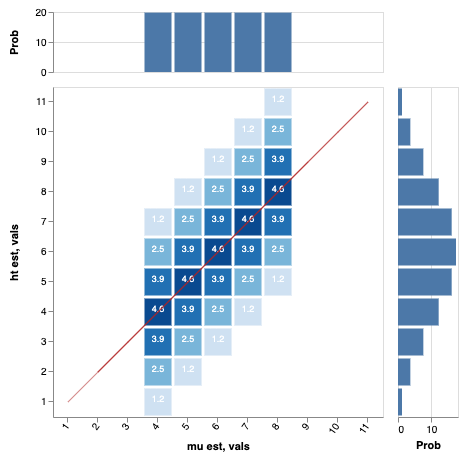

In [16]:
-- vlShow . sidewaysDists <$> forM domain (\x ->
--   titled (show x ++ "'s Height Prior") . barFromDist <$> enumD (($ x) . ht . fst <$> indicesPriorFlat)
--   )
vlShow . margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)

Exogenous costs influence the prior likelihoods of utterances

In [17]:
cost :: Utt -> Double
cost UNone = 0
cost UTall = 1
cost UShrt = 2

utterancePrior1 :: Model Utt
utterancePrior1 = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

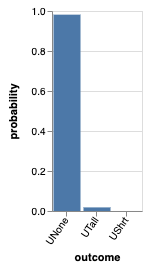

In [18]:
vlShow . barFromDist <$> enumD utterancePrior1

# And

## Positive Utterances

Keeping all priors about indices and utterances the same, we now model pragmatic listeners who consider various strengthenings of the assertion (note that these are strengthenings in the *dynamic sense*; the pure informational content about John's and Mary's heights is the same in all lexica)

Baseline `andDen0` of both antonyms is that they are tautologies (John and Mary are within 2 steps of the median)

On other interpretations, 'Tall' (resp. 'Short') places **both** John and Mary in a certain upper (resp. lower) percentile of the comparison class

\begin{align}
[\![\text{John and Mary are tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \forall x.\,\textsf{ht}_w(x) \geq \mu + \sigma\\
[\![\text{John and Mary are short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \forall x.\,\textsf{ht}_w(x) \leq \mu + \sigma
\end{align}

In [19]:
andDen0 :: Lexicon
andDen0 = Lex 0 f
  where f _ = indices

posAndDens :: [Lexicon]
posAndDens =
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> all (\x -> ht w x >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> all (\x -> ht w x <= i + d) domain) indices
     return (Lex d f)

In [20]:
infoBaselineAnd = Priors indicesPriorFlat utterancePrior1 (unif [andDen0])
infoLUMAnd = infoBaselineAnd {lp = unif posAndDens}

### Pragmatic agents

#### Pragmatic listener hears:

> "John and Mary are tall"

These agents become very confident that John's height exceeds the class standard, though they remain in the dark about what that standard is (the conclusions for Mary are identical)

And as seen in the `ht est` marginal, even though the standard remains unknown, the belief that John's height exceeds it leads to a (positively skewed) evaluative distribution over worlds

The resulting evaluative inference is robust, but not extreme

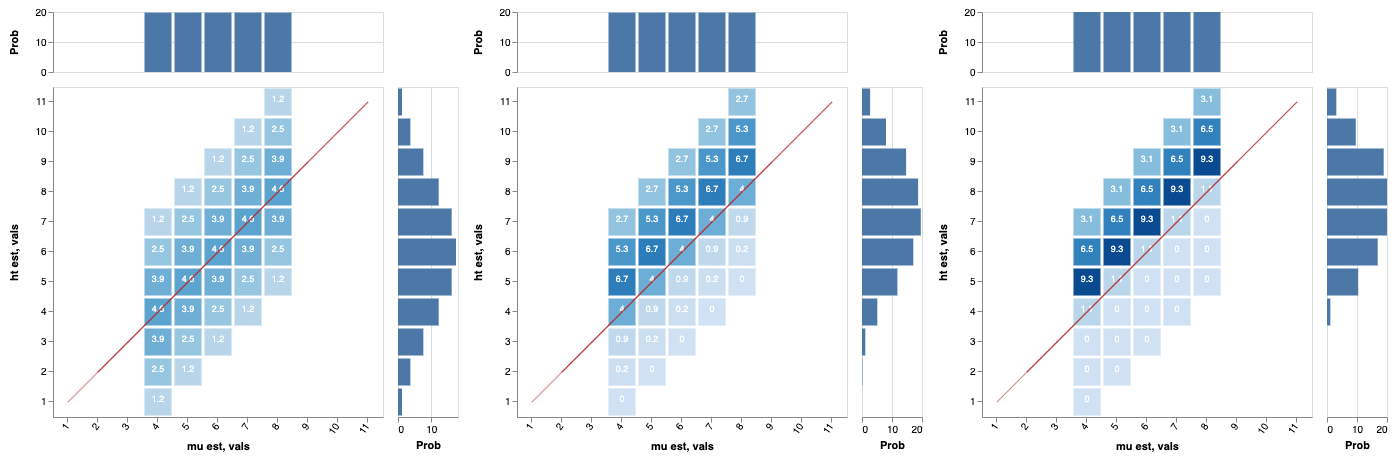

In [21]:
writeIORef cacheRef (0, Map.empty)
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAnd cacheRef (0, UTall, andDen0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAnd cacheRef (1, UTall, andDen0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAnd cacheRef (2, UTall, andDen0))
  ]

#### Pragmatic listener hears:

> "John and Mary are short"

These agents become quite certain that John's height falls below the class standard, though they remain in the dark about what that standard is (the conclusions for Mary are identical)

And as seen in the `ht est` marginal, even though the standard remains unknown, the belief that John's height falls below it it leads to a (negatively skewed) evaluative distribution over worlds

The evaluativity effect is almost perfectly symmetrical to the positive case

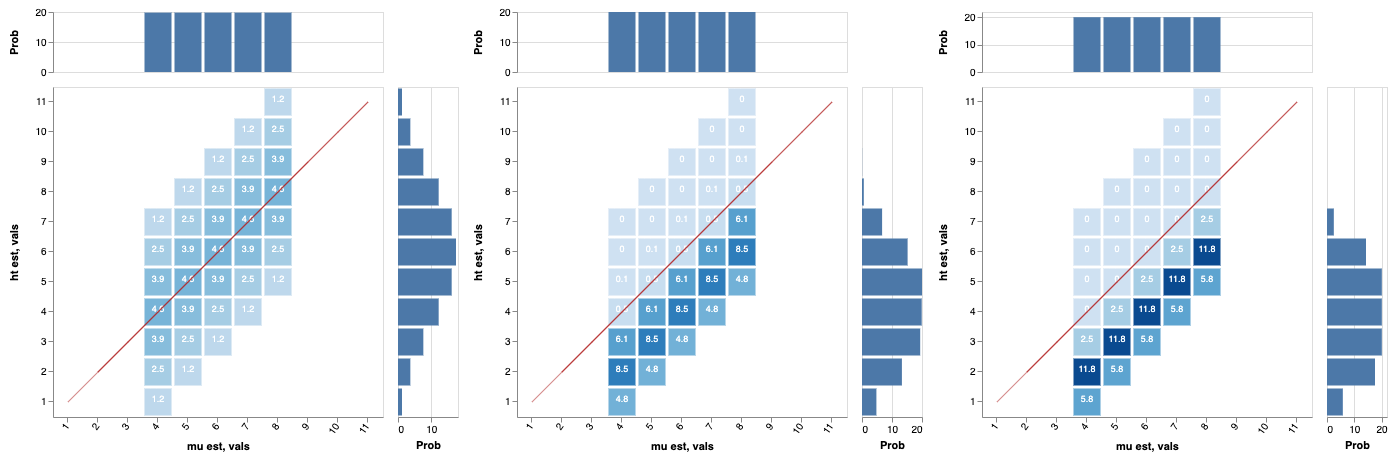

In [22]:
writeIORef cacheRef (0, Map.empty)
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAnd cacheRef (0, UShrt, andDen0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAnd cacheRef (1, UShrt, andDen0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAnd cacheRef (2, UShrt, andDen0))
  ]

## Degree demonstrative

All adjectival utterances are now interpreted as entailing that John's and Mary's heights are 6

In the baseline lexicon `AndDenExact0`, this is all that is contributed by an utterance

Other interpretations place their heights at 6 and additionally guarantee that those heights are within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{John and Mary are 6-tall}]\!]_{\sigma} := \lambda \langle w,\mu\rangle.\, \forall x.\,\textsf{ht}_w(x) = 6 \land 6 \geq \mu + \sigma\end{equation}

In [23]:
andDenExact0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> all (\x -> ht w x == 6) domain) indices
        f UShrt = filter (\(w,i) -> all (\x -> ht w x == 6) domain) indices

exactAndDens :: [Lexicon]
exactAndDens = 
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> all (\x -> ht w x == 6 && 6 >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> all (\x -> ht w x == 6 && 6 <= i + d) domain) indices
     return (Lex d f)

### Pragmatic agents

#### Pragmatic listener hears

> "Bill's height is 6; John and Mary are that tall too"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings

In [24]:
infoLUMAndExact = infoBaselineAnd {lp = unif exactAndDens}

Of course since all of the lexica entail that John's and Mary's heights are 6, the distribution over worlds is completely determinate

The various conceivable strengthenings lead ultimately to a pragmatic conclusion that 6 is probably normal for the height of someone in the comparison class (this was already guaranteed by the prior), but it's possible that 6 is relatively high compared to the median

In other words, if there is any evaluativity effect, it is very weak

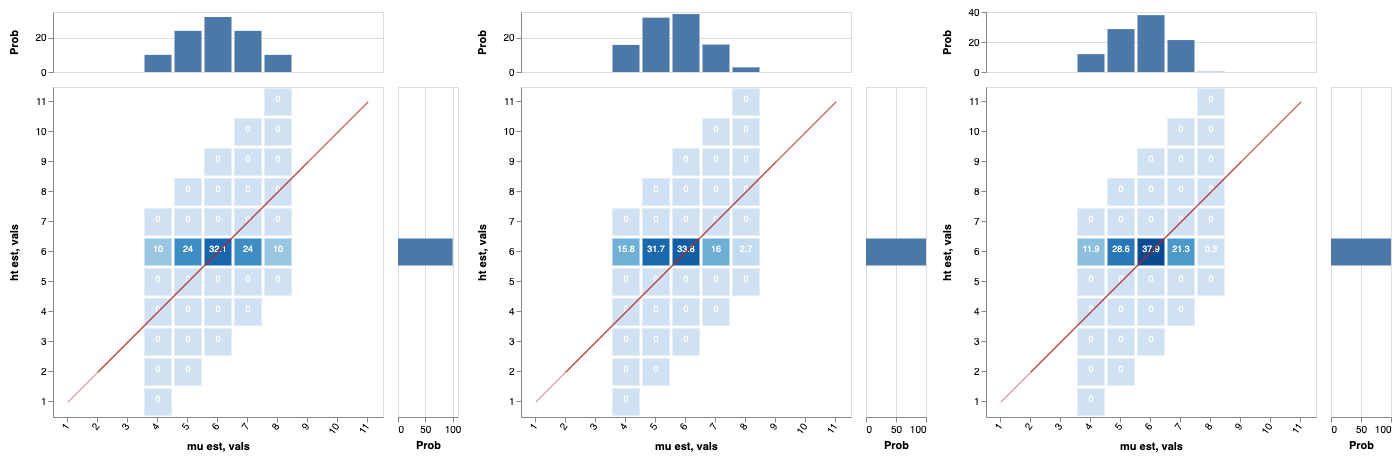

In [25]:
writeIORef cacheRef (0, Map.empty)
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndExact cacheRef (0, UTall, andDenExact0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndExact cacheRef (1, UTall, andDenExact0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndExact cacheRef (2, UTall, andDenExact0))
  ]

#### Pragmatic listener hears:

> "Bill's height is 6; John and Mary are that short too"

Again, since the lexica all entail that a "6-short person" has height 6, the distribution over worlds is certain

But now, the various strengthenings lead ultimately to a pragmatic conclusion that 6 is almost certainly below the median

The evaluativity effect here is much stronger

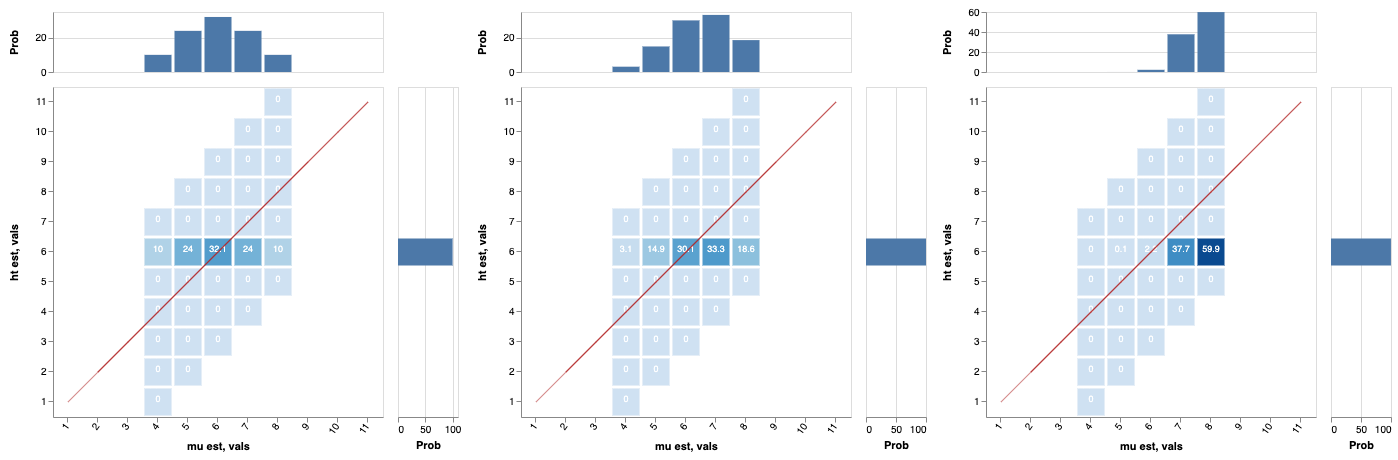

In [26]:
writeIORef cacheRef (0, Map.empty) 
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndExact cacheRef (0, UShrt, andDenExact0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndExact cacheRef (1, UShrt, andDenExact0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndExact cacheRef (2, UShrt, andDenExact0))
  ]

## Uncertain Equative

All adjectival utterances are now interpreted as entailing that John's and Mary's heights are equal to Bill's height, but Bill's height is not known.

There is no real baseline here, since there is no privileged belief for Bill's height, but let's arbitrarily set it at $6$.

Other interpretations place John's and Mary's heights at other values, and additionally guarantee that those heights are within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{John and Mary are Bill-tall}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \forall x.\,\textsf{ht}_w(x) = b \land b \geq \mu + \sigma\end{equation}

[eqDens in pictures](eqDens.vl)

In [27]:
andDenEq0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> all (\x -> ht w x == 6) domain) indices
        f UShrt = filter (\(w,i) -> all (\x -> ht w x == 6) domain) indices

eqAndDens :: [Lexicon]
eqAndDens = 
  do d <- [-sigma .. sigma] :: [Int]
     b <- [4 .. 8]
     let f UNone = indices
         f UTall = filter (\(w,i) -> all (\x -> ht w x == b && b >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> all (\x -> ht w x == b && b <= i + d) domain) indices
     return (Lex (d * 10 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "John and Mary are as tall as Bill"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings.

In [28]:
infoLUMAndEq = infoBaselineAnd {lp = unif eqAndDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that John is probably of normal height for someone in the comparison class (this was already guaranteed by the prior), though it's possible that he is relatively tall compared to the median (the conclusions for Mary are identical)

Again, we might say if there's any evaluativity here at all, it is very weak

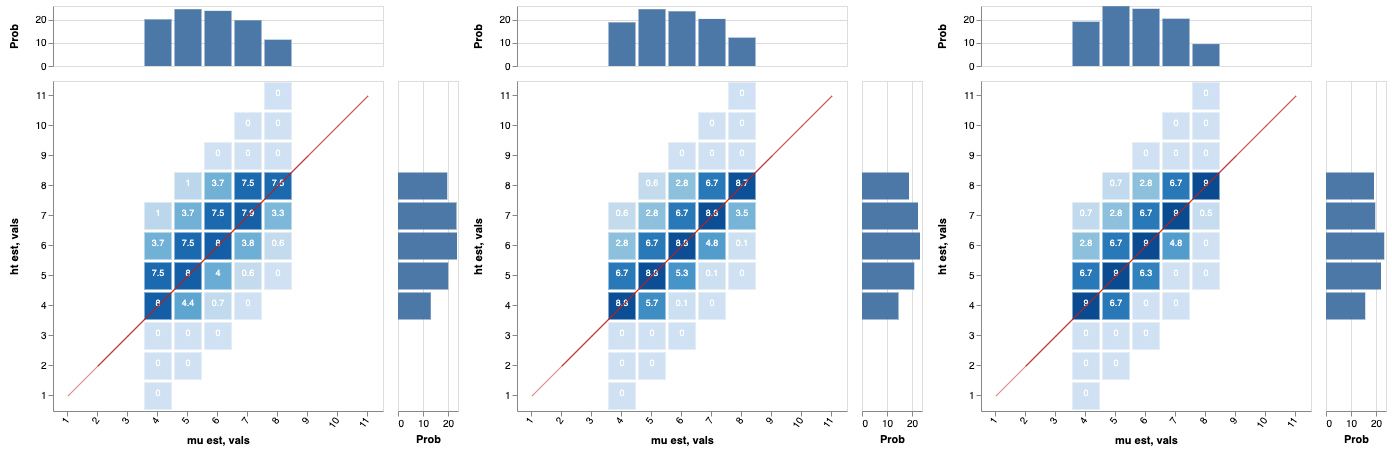

In [29]:
writeIORef cacheRef (0, Map.empty)
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    -- margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndEq cacheRef (0, UTall, denEq0))
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndEq cacheRef (1, UTall, andDenEq0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndEq cacheRef (2, UTall, andDenEq0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndEq cacheRef (3, UTall, andDenEq0))
  ]

#### Pragmatic listener hears:

> "John and Mary are as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights.

But now, the various strengthenings lead ultimately to a pragmatic conclusion that John is almost certainly below the median (same for Mary)

As expected, the evaluative effect is much stronger

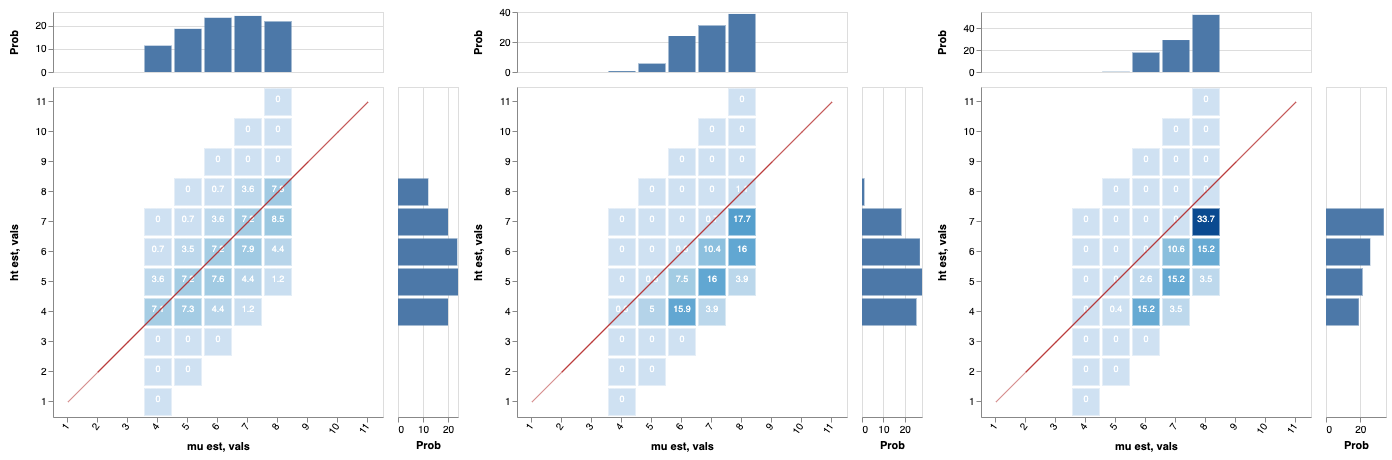

In [30]:
writeIORef cacheRef (0, Map.empty)  
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    -- margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMEq cacheRef (0, UShrt, denEq0))
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndEq cacheRef (1, UShrt, andDenEq0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndEq cacheRef (2, UShrt, andDenEq0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMAndEq cacheRef (3, UShrt, andDenEq0))
  ]

# Or

## Positive Utterances

Keeping all priors about indices and utterances the same, we now model pragmatic listeners who consider various strengthenings of the assertion (note that these are strengthenings in the *dynamic sense*; the pure informational content about John's and Mary's heights is the same in all lexica)

Baseline `orDen0` of both antonyms is that they are tautologies (John and Mary are within 2 steps of the median)

On other interpretations, 'Tall' (resp. 'Short') places **either** John or Mary in a certain upper (resp. lower) percentile of the comparison class

\begin{align}
[\![\text{John or Mary is tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \exists x.\,\textsf{ht}_w(x) \geq \mu + \sigma\\
[\![\text{John or Mary is short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \exists x.\,\textsf{ht}_w(x) \leq \mu + \sigma
\end{align}

In [31]:
orDen0 :: Lexicon
orDen0 = Lex 0 f
  where f _ = indices

posOrDens :: [Lexicon]
posOrDens =
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> any (\x -> ht w x >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> any (\x -> ht w x <= i + d) domain) indices
     return (Lex d f)

In [32]:
infoBaselineOr = Priors indicesPriorFlat utterancePrior1 (unif [orDen0])
infoLUMOr = infoBaselineOr {lp = unif posOrDens}

### Pragmatic agents

#### Pragmatic listener hears:

> "John or Mary is tall"

These agents become very confident that John's height exceeds the class standard, though they remain in the dark about what that standard is (the conclusions for Mary are identical)

And as seen in the `ht est` marginal, even though the standard remains unknown, the belief that John's height exceeds it leads to a (positively skewed) evaluative distribution over worlds

The resulting evaluative inference is robust, but not extreme

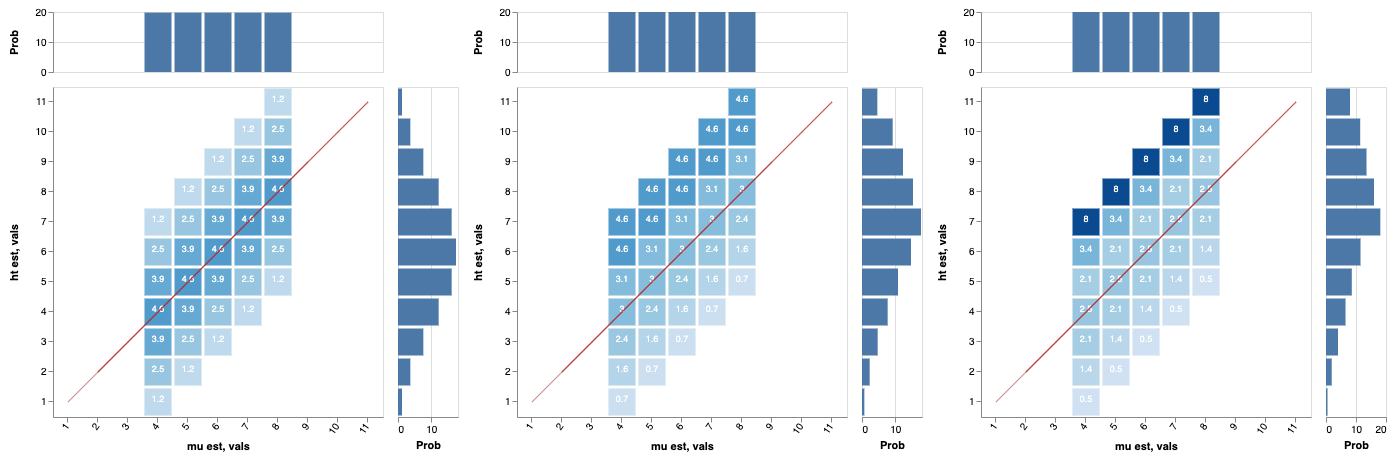

In [33]:
writeIORef cacheRef (0, Map.empty)
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOr cacheRef (0, UTall, orDen0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOr cacheRef (1, UTall, orDen0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOr cacheRef (2, UTall, orDen0))
  ]

#### Pragmatic listener hears:

> "John and Mary are short"

These agents become quite certain that John's height falls below the class standard, though they remain in the dark about what that standard is (the conclusions for Mary are identical)

And as seen in the `ht est` marginal, even though the standard remains unknown, the belief that John's height falls below it it leads to a (negatively skewed) evaluative distribution over worlds

The evaluativity effect is almost perfectly symmetrical to the positive case

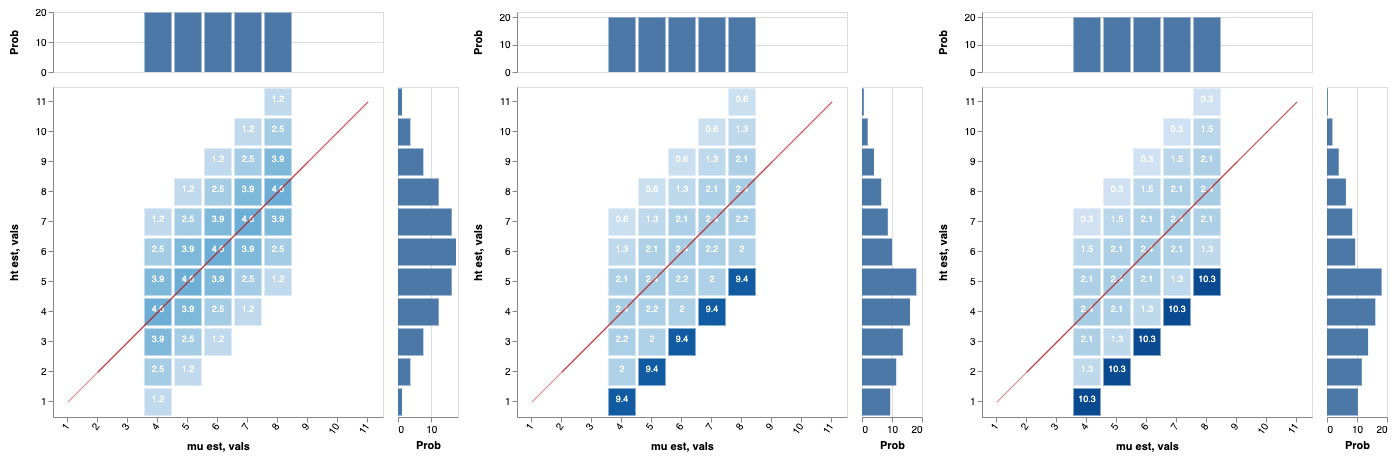

In [34]:
writeIORef cacheRef (0, Map.empty)
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOr cacheRef (0, UShrt, orDen0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOr cacheRef (1, UShrt, orDen0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOr cacheRef (2, UShrt, orDen0))
  ]

## Degree demonstrative

All adjectival utterances are now interpreted as entailing that John's and Mary's heights are 6

In the baseline lexicon `orDenExact0`, this is all that is contributed by an utterance

Other interpretations place their heights at 6 and additionally guarantee that those heights are within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{John or Mary is 6-tall}]\!]_{\sigma} := \lambda \langle w,\mu\rangle.\, \exists x.\,\textsf{ht}_w(x) = 6 \land 6 \geq \mu + \sigma\end{equation}

In [35]:
orDenExact0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> any (\x -> ht w x == 6) domain) indices
        f UShrt = filter (\(w,i) -> any (\x -> ht w x == 6) domain) indices

exactOrDens :: [Lexicon]
exactOrDens = 
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> any (\x -> ht w x == 6 && 6 >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> any (\x -> ht w x == 6 && 6 <= i + d) domain) indices
     return (Lex d f)

### Pragmatic agents

#### Pragmatic listener hears

> "Bill's height is 6; John and Mary are that tall too"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings

In [36]:
infoLUMOrExact = infoBaselineOr {lp = unif exactOrDens}

Of course since all of the lexica entail that John's and Mary's heights are 6, the distribution over worlds is completely determinate

The various conceivable strengthenings lead ultimately to a pragmatic conclusion that 6 is probably normal for the height of someone in the comparison class (this was already guaranteed by the prior), but it's possible that 6 is relatively high compared to the median

In other words, if there is any evaluativity effect, it is very weak

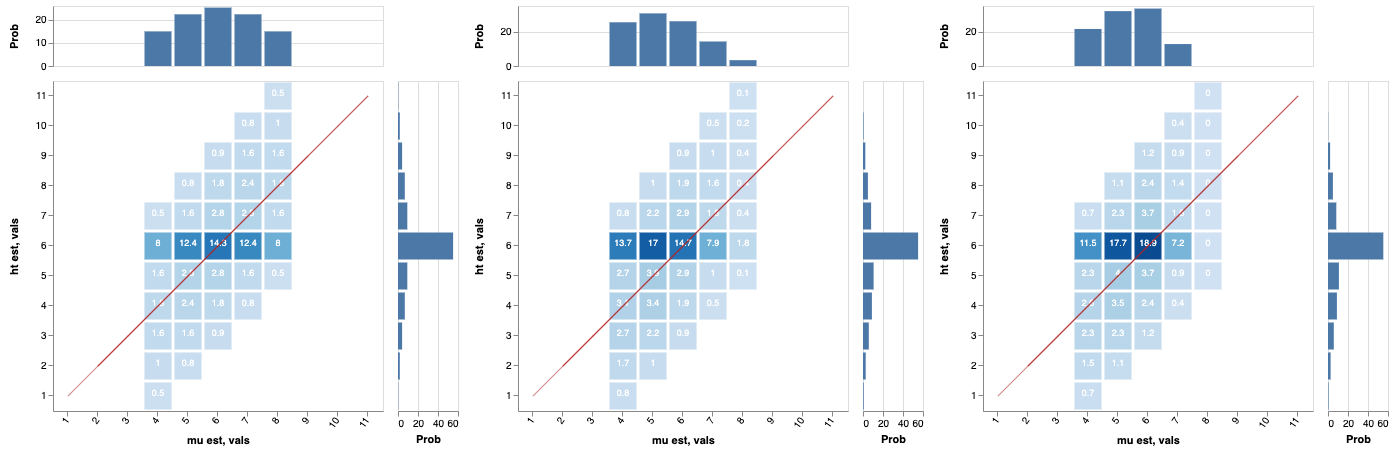

In [37]:
writeIORef cacheRef (0, Map.empty)
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrExact cacheRef (0, UTall, orDenExact0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrExact cacheRef (1, UTall, orDenExact0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrExact cacheRef (2, UTall, orDenExact0))
  ]

#### Pragmatic listener hears:

> "Bill's height is 6; John and Mary are that short too"

Again, since the lexica all entail that a "6-short person" has height 6, the distribution over worlds is certain

But now, the various strengthenings lead ultimately to a pragmatic conclusion that 6 is almost certainly below the median

The evaluativity effect here is much stronger

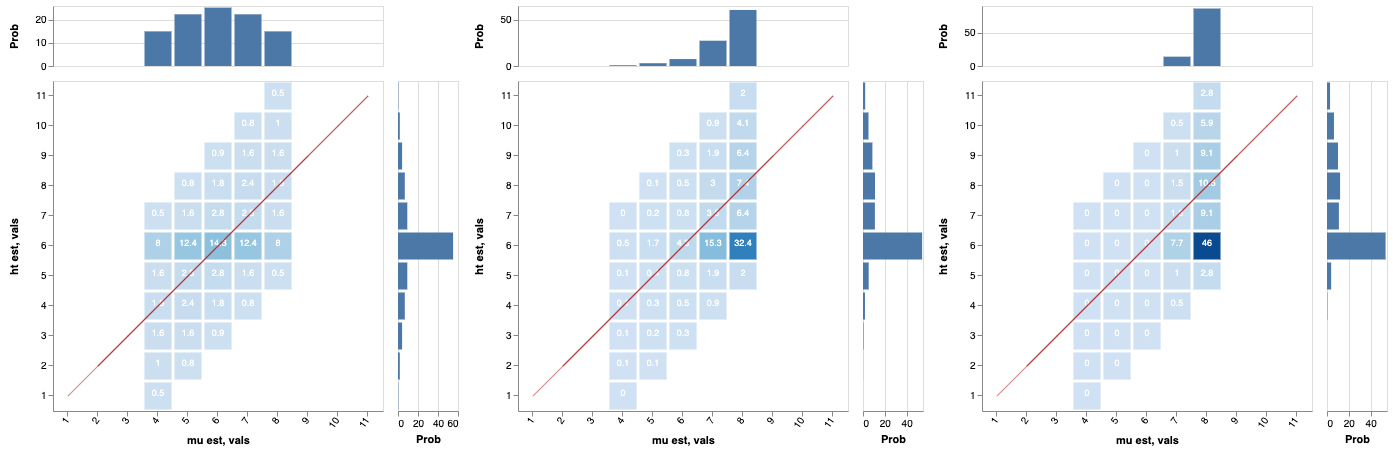

In [38]:
writeIORef cacheRef (0, Map.empty) 
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrExact cacheRef (0, UShrt, orDenExact0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrExact cacheRef (1, UShrt, orDenExact0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrExact cacheRef (2, UShrt, orDenExact0))
  ]

## Uncertain Equative

All adjectival utterances are now interpreted as entailing that John's and Mary's heights are equal to Bill's height, but Bill's height is not known.

There is no real baseline here, since there is no privileged belief for Bill's height, but let's arbitrarily set it at $6$.

Other interpretations place John's and Mary's heights at other values, and additionally guarantee that those heights are within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{John or Mary is Bill-tall}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \exists x.\,\textsf{ht}_w(x) = b \land b \geq \mu + \sigma\end{equation}

[eqDens in pictures](eqDens.vl)

In [39]:
orDenEq0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> any (\x -> ht w x == 6) domain) indices
        f UShrt = filter (\(w,i) -> any (\x -> ht w x == 6) domain) indices

eqOrDens :: [Lexicon]
eqOrDens = 
  do d <- [-sigma .. sigma] :: [Int]
     b <- [4 .. 8]
     let f UNone = indices
         f UTall = filter (\(w,i) -> any (\x -> ht w x == b && b >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> any (\x -> ht w x == b && b <= i + d) domain) indices
     return (Lex (d * 10 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "John or Mary is as tall as Bill"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings.

In [40]:
infoLUMOrEq = infoBaselineOr {lp = unif eqOrDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that John is probably of normal height for someone in the comparison class (this was already guaranteed by the prior), though it's possible that he is relatively tall compared to the median (the conclusions for Mary are identical)

Again, we might say if there's any evaluativity here at all, it is very weak

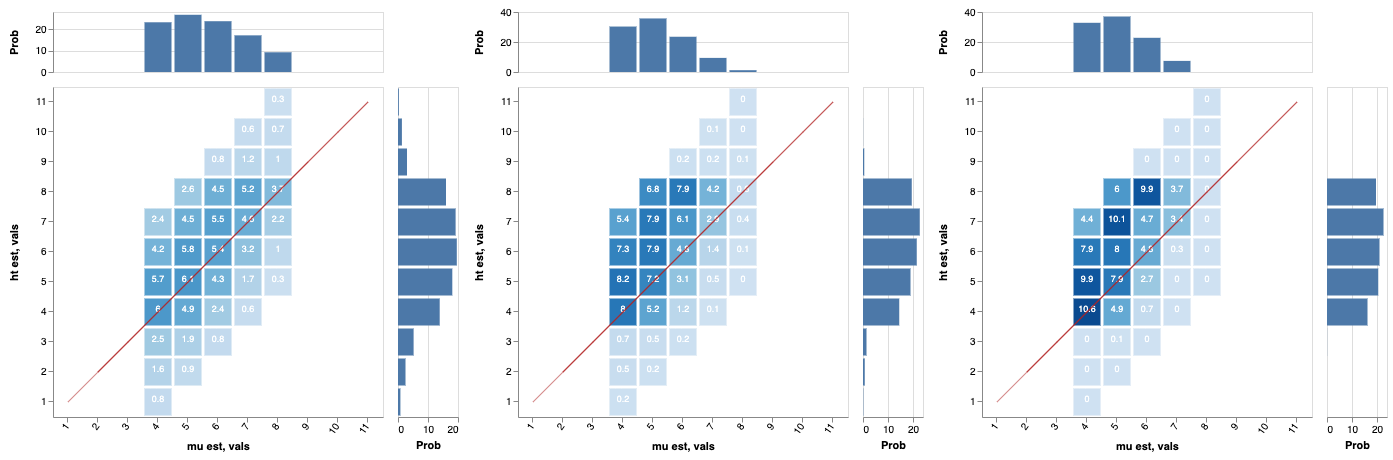

In [41]:
writeIORef cacheRef (0, Map.empty)
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    -- margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMEq cacheRef (0, UTall, denEq0))
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrEq cacheRef (1, UTall, orDenEq0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrEq cacheRef (2, UTall, orDenEq0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrEq cacheRef (3, UTall, orDenEq0))
  ]

#### Pragmatic listener hears:

> "John or Mary is as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights.

But now, the various strengthenings lead ultimately to a pragmatic conclusion that John is almost certainly below the median (same for Mary)

As expected, the evaluative effect is much stronger

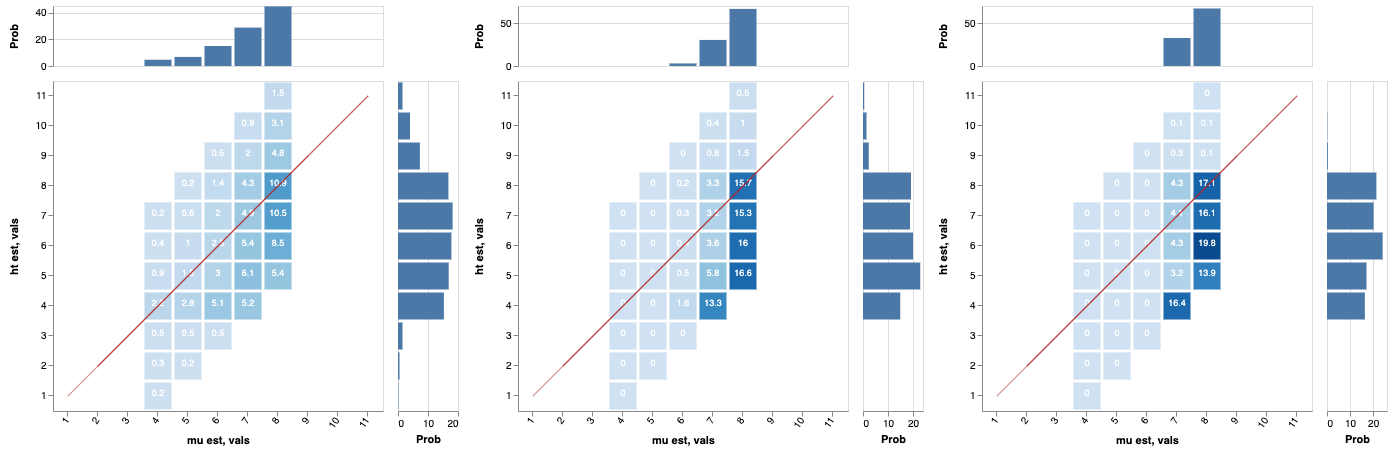

In [42]:
writeIORef cacheRef (0, Map.empty)  
vlShow . sidewaysDists <$> sequence
  [ -- margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)
    -- margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMEq cacheRef (0, UShrt, denEq0))
    margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrEq cacheRef (1, UShrt, orDenEq0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrEq cacheRef (2, UShrt, orDenEq0))
  , margHeatFromDist <$> enumD (first (`ht` John) <$> listener infoLUMOrEq cacheRef (3, UShrt, orDenEq0))
  ]